In [4]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
import os
import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.utils import export_to_video
import cv2
import copy

os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

In [7]:
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [3]:
# URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
# download_dir = pathlib.Path('./UCF101_subset/')
# subset_paths = download_ufc_101_subset(URL, 
#                         num_classes = 10, 
#                         splits = {"train": 30, "val": 10, "test": 10},
#                         download_dir = download_dir)

In [5]:
subset_paths = {'train': pathlib.Path('UCF101_subset/train'), 'val': pathlib.Path('UCF101_subset/val'), 'test': pathlib.Path('UCF101_subset/test')}

In [8]:
HEIGHT = 150
WIDTH = 150

n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

history_data = {'accuracy':[], 'loss':[], 'val_accuracy':[], 'val_loss':[]}

2024-11-08 11:34:54.186893: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-08 11:34:54.206549: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)
  
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])


class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [10]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [13]:
frames, label = next(iter(train_ds))
model.build(frames)

model.summary()

2024-11-07 20:59:57.386540: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48168960 exceeds 10% of free system memory.


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 10, 150,   │          0 │ -                 │
│ (InputLayer)        │ 150, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_plus1d_1      │ (None, 10, 150,   │      3,152 │ input_layer_2[0]… │
│ (Conv2Plus1D)       │ 150, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 150,   │         64 │ conv2_plus1d_1[0… │
│ (BatchNormalizatio… │ 150, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 10, 150,   │          0 │ batch_normalizat… │
│                     │ 150, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_video_1      │ (None, 10, 75,    │          0 │ re_lu_1[0][0]     │
│ (ResizeVideo)       │ 75, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_main       │ (None, 10, 75,    │      6,272 │ resize_video_1[0… │
│ (ResidualMain)      │ 75, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 75,    │          0 │ resize_video_1[0… │
│                     │ 75, 16)           │            │ residual_main[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_video_2      │ (None, 10, 37,    │          0 │ add[0][0]         │
│ (ResizeVideo)       │ 37, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ project (Project)   │ (None, 10, 37,    │        608 │ resize_video_2[0… │
│                     │ 37, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_main_1     │ (None, 10, 37,    │     20,224 │ resize_video_2[0… │
│ (ResidualMain)      │ 37, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 37,    │          0 │ project[0][0],    │
│                     │ 37, 32)           │            │ residual_main_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_video_3      │ (None, 10, 18,    │          0 │ add_1[0][0]       │
│ (ResizeVideo)       │ 18, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ project_1 (Project) │ (None, 10, 18,    │      2,240 │ resize_video_3[0… │
│                     │ 18, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_main_2     │ (None, 10, 18,    │     80,384 │ resize_video_3[0… │
│ (ResidualMain)      │ 18, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 18,    │          0 │ project_1[0][0],  │
│                     │ 18, 64)           │            │ residual_main_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_video_4      │ (None, 10, 9, 9,  │          0 │ add_2[0][0]       │
│ (ResizeVideo)       │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ project_2 (Project) │ (None, 10, 9, 9,  │      8,576 │ resize_video_4[0

 Total params: 443,322 (1.69 MB)

 Trainable params: 443,290 (1.69 MB)

 Non-trainable params: 32 (128.00 B)

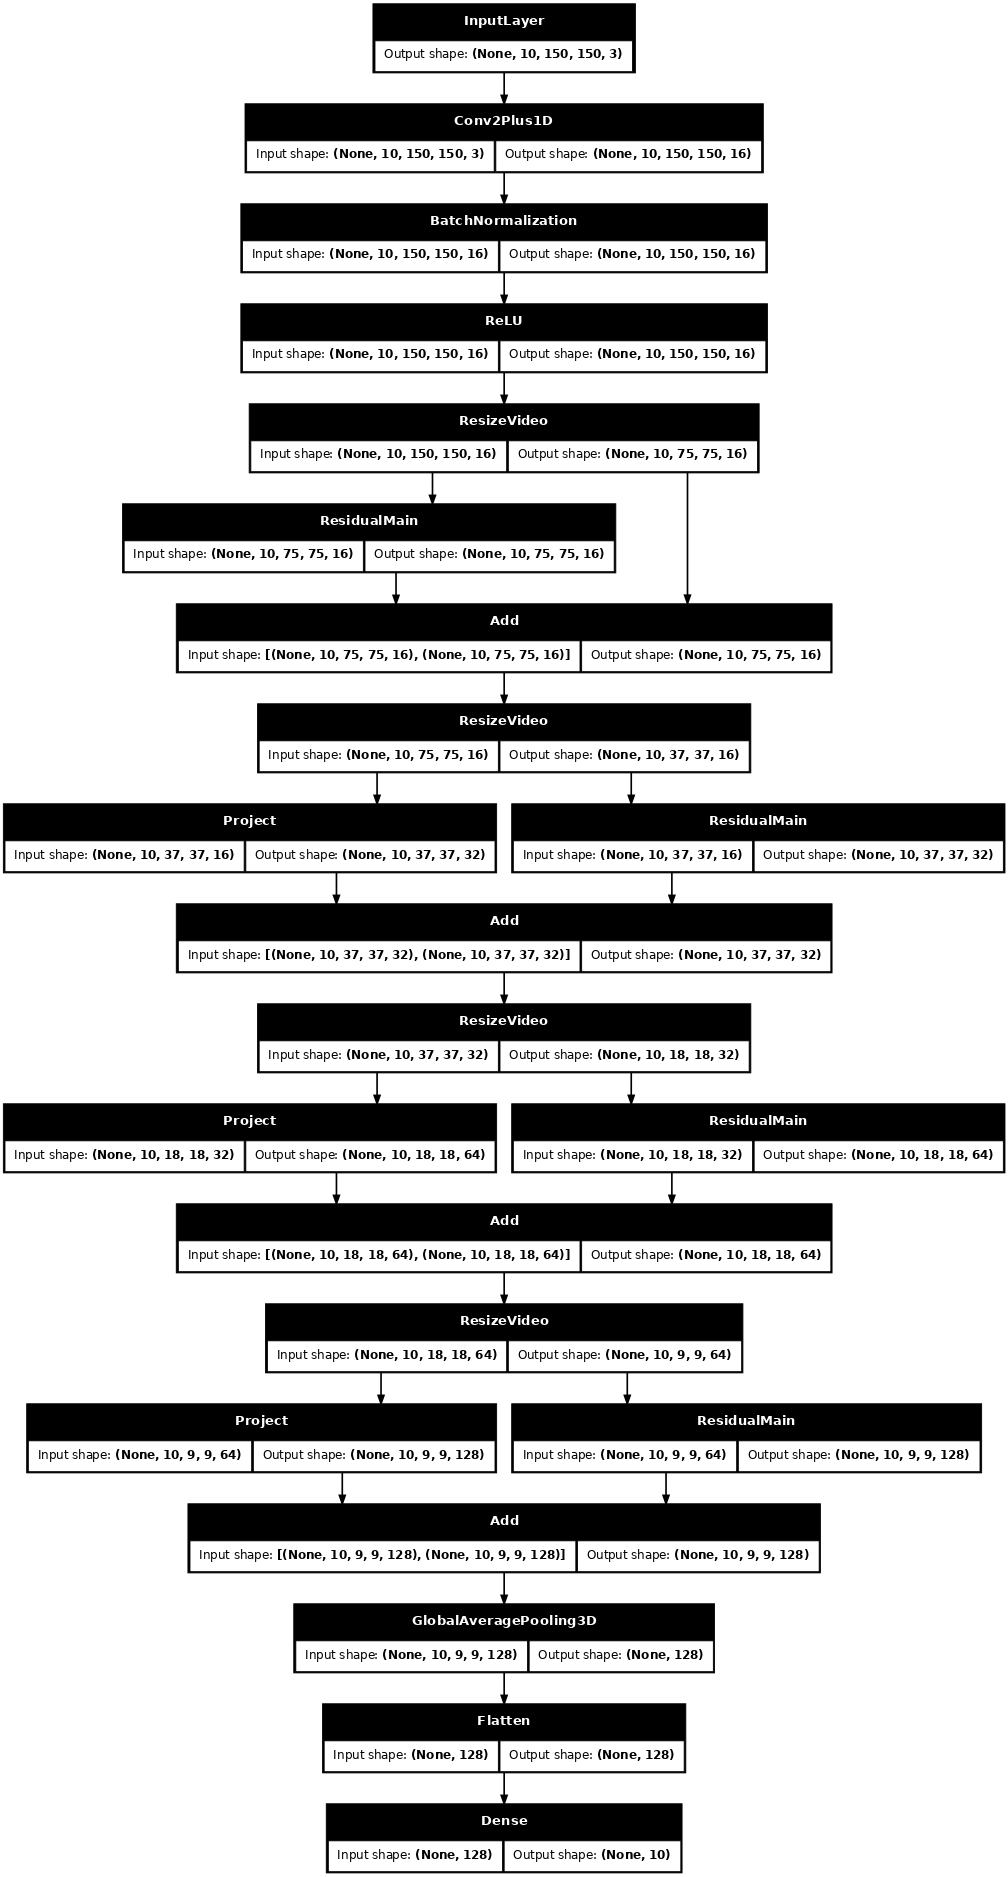

In [11]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [15]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])

In [ ]:
history = model.fit(x = train_ds, epochs = 10, validation_data = val_ds)

In [16]:
history_data = {'accuracy': [0.2142857164144516,
  0.31385281682014465,
  0.37012988328933716,
  0.4523809552192688,
  0.46536797285079956,
  0.5432900190353394,
  0.551948070526123,
  0.5757575631141663,
  0.6168830990791321,
  0.6082251071929932,
  0.6385281682014465,
  0.6515151262283325,
  0.6601731777191162,
  0.6839826703071594,
  0.7056276798248291,
  0.677489161491394,
  0.7294372320175171,
  0.7294372320175171,
  0.7186146974563599,
  0.738095223903656],
 'loss': [2.2236380577087402,
  1.9542049169540405,
  1.7800718545913696,
  1.5881649255752563,
  1.5647879838943481,
  1.381790041923523,
  1.31675386428833,
  1.2530393600463867,
  1.1656228303909302,
  1.1053072214126587,
  1.0417968034744263,
  1.0151253938674927,
  0.9698920249938965,
  0.9183856248855591,
  0.8665485382080078,
  0.850485622882843,
  0.7931793928146362,
  0.7532979249954224,
  0.783280611038208,
  0.7503343820571899],
 'val_accuracy': [0.1808510571718216,
  0.228723406791687,
  0.21276596188545227,
  0.26595744490623474,
  0.28723403811454773,
  0.3882978856563568,
  0.4893617033958435,
  0.3882978856563568,
  0.6329787373542786,
  0.5744680762290955,
  0.5691489577293396,
  0.5585106611251831,
  0.6755319237709045,
  0.6170212626457214,
  0.7127659320831299,
  0.707446813583374,
  0.707446813583374,
  0.5797872543334961,
  0.707446813583374,
  0.7659574747085571],
 'val_loss': [2.2813730239868164,
  2.335801124572754,
  2.356163501739502,
  2.121961832046509,
  2.300626039505005,
  1.7857706546783447,
  1.6485520601272583,
  1.7781085968017578,
  1.1681303977966309,
  1.3011085987091064,
  1.249394416809082,
  1.2422882318496704,
  0.9962731003761292,
  1.1116210222244263,
  0.8015487194061279,
  0.7737817764282227,
  0.8066276907920837,
  1.2088265419006348,
  0.9084100127220154,
  0.7408503890037537]}

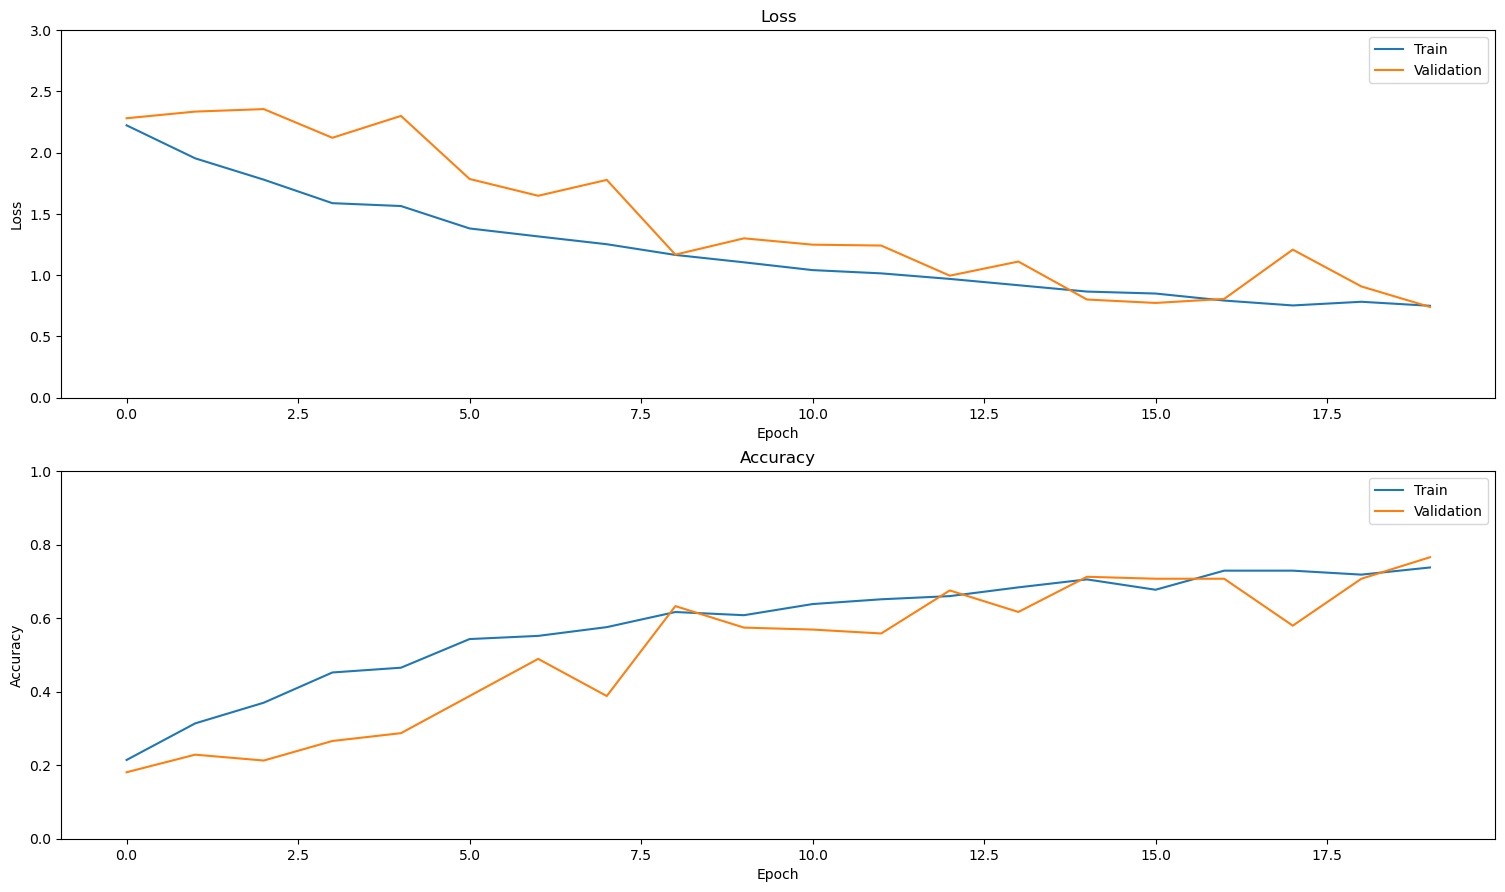

In [17]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history_data['loss'], label = 'train')
  ax1.plot(history_data['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history_data['loss'] + history_data['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history_data['accuracy'],  label = 'train')
  ax2.plot(history_data['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history_data)

In [20]:
pipe = DiffusionPipeline.from_pretrained("damo-vilab/text-to-video-ms-1.7b", torch_dtype=torch.float16, variant="fp16")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to('cuda')

Couldn't connect to the Hub: (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 6981ba16-7de8-463f-bdf1-f60ba3886f84)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
prompt = "horse riding"
video_frames = pipe(prompt, num_inference_steps=24, num_frames=20).frames

  0%|          | 0/24 [00:00<?, ?it/s]

In [22]:
video_path = export_to_video(video_frames[0],output_video_path='/home/omnissiah/Minor/minor_project/models/asd.mp4')

video_path

'/home/omnissiah/Minor/minor_project/models/asd.mp4'

In [18]:
def get_frames(video_path):
    plot = []
    video = cv2.VideoCapture(video_path)        
    a = True
    
    while a:
        a,image = video.read() # BGR format
        
        if a:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = np.array(image)
            plot.append(copy.deepcopy(image/255.0))
        
    return plot

frames = get_frames(video_path)

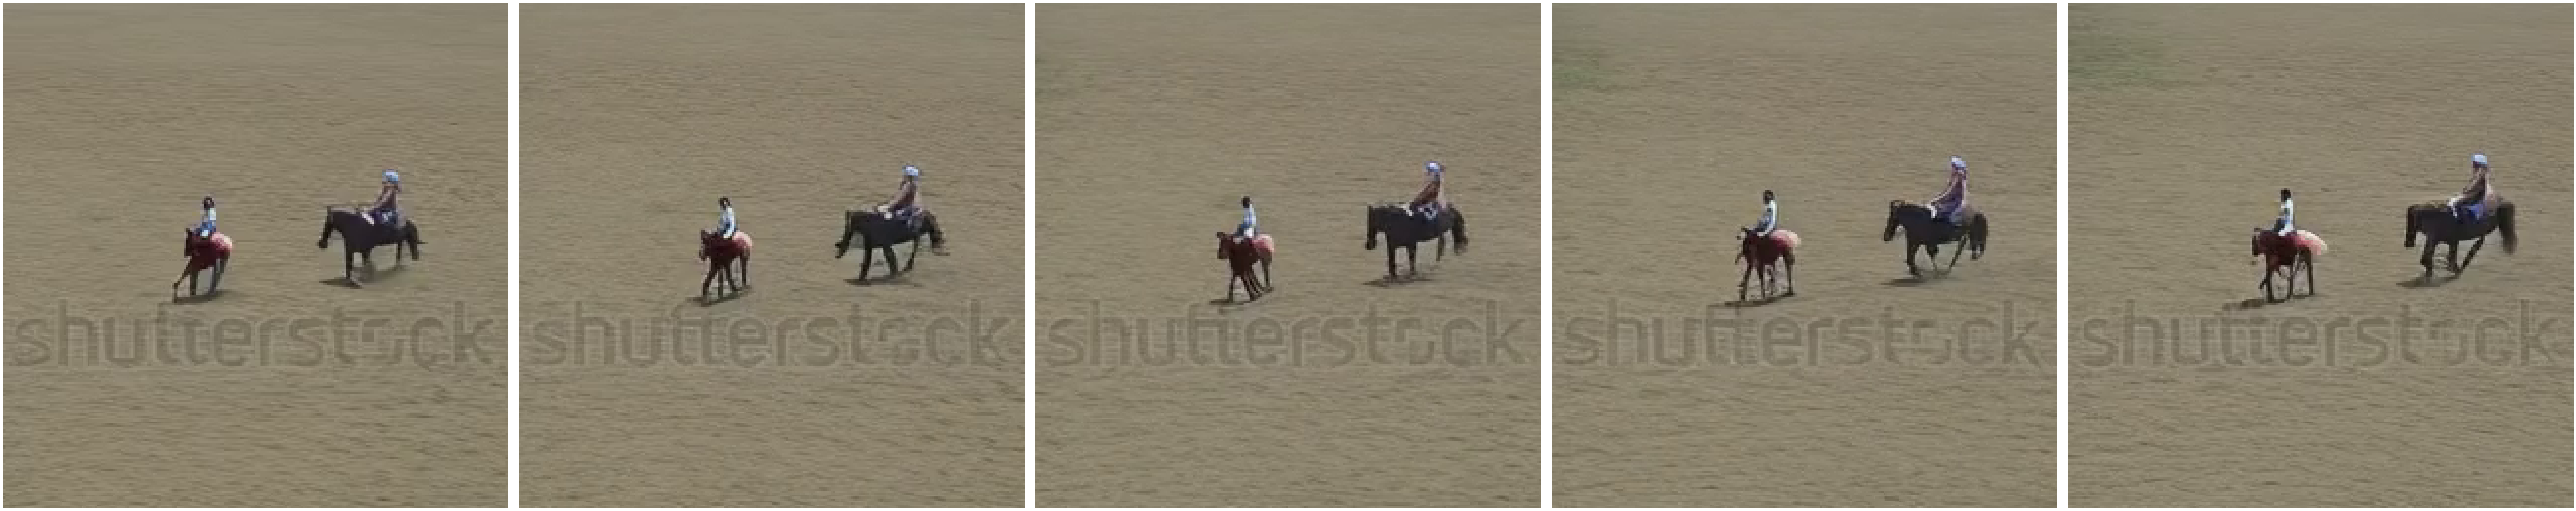

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(100, 100))
idx = 0
for i in range(20):
    axes[idx].imshow(frames[i])
    axes[idx].axis('off')
    
    idx+=1
    if idx==5: break  
    
plt.tight_layout(pad=3)
plt.show()